## Spatial model

### Comments Michiel
* Why do we need `json` ("lightweight data interchange format inspired by JavaScript object literal syntax")
* ... `corner` ("An illustrative representation of different projections of samples in high dimensional spaces", make beautiful corner plots for demonstrating the parameter distributions)
* `mdates`: `Matplotlib` provides sophisticated date plotting capabilities, standing on the shoulders of python `datetime` and the add-on module `dateutil`
* `xarray`: "Xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays"
* `emcee`: "emcee is an MIT licensed pure-Python implementation of Goodman & Weare’s Affine Invariant Markov chain Monte Carlo (**MCMC**) Ensemble sampler and these pages will show you how to use it."
* Then there are quite some functions and procedures used from the custom package `covid19model` which are probably good to go through
* `%load_ext autoreload`: "IPython extension to reload modules before executing user code"
* `%autoreload 2`: "Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.". This may be useful because the `covid19model` package is under construction.

Note: it is of interest to go over all of the function loaded here

In [1]:
import random
import os
import numpy as np
import json
import corner
import random
import os

import pandas as pd
import geopandas as gp
import datetime
import scipy
import matplotlib
import matplotlib.colors as colors
import matplotlib.dates as mdates
import math
import xarray as xr
import emcee
import matplotlib.pyplot as plt

from covid19model.optimization import objective_fcns
from covid19model.models import models
from covid19model.models.utils import name2nis
from covid19model.data import google, sciensano, polymod, model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

### Check name2nis functionality

#### Comments Michiel
* At first the function below loaded pickle files, but this raised the exception Pickle Protocol 5. This is solved by simply loading CSV files.
* The `name2nis` function reads the `NIS_name.csv` and translates names to NIS codes, pretty simple stuff.

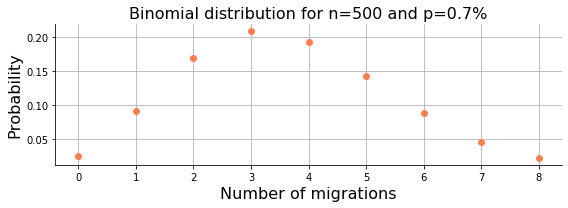

In [14]:
from scipy.stats import binom
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8,3))


# mortality for fourty-year-olds
n, p = 500, 1 - np.exp(-(1-0.857)/19.3)
mean, var, skew, kurt = binom.stats(n, p, moments='mvsk')

x = np.arange(binom.ppf(0.01, n, p),
              binom.ppf(0.99, n, p))
ax.plot(x, binom.pmf(x, n, p), 'bo', label='binom pmf', color='coral')
ax.set_xlabel('Number of migrations', size=16)
ax.set_ylabel('Probability', size=16)
ax.set_title('Binomial distribution for n=500 and p=0.7%', size=16)
plt.tight_layout()
# ax.vlines(x, 0, binom.pmf(x, n, p), colors='b', lw=5, alpha=0.5)
#plt.savefig('test')

In [9]:
print(1- np.exp(-(1-0.857)/19.3))

0.007381945033458903


In [2]:
# Test
name2nis('Arrondissement Roeselare')

36000

In [3]:
# Test
name2nis('arrondissement Roeselare')

36000

In [30]:
# Test
#name2nis('Arrondissement oeselare')

In [31]:
# Test
#name2nis(5)

### Extract population size (initN)

#### Comments Michiel
* Read the initial population size as a dataframe, ordered by NIS-code, name, total population, age-stratified population
* ...

In [4]:
# Read CSV as dataframe with the first column (NIS) as index
initN_df=pd.read_csv('../../data/interim/census_2011/initN.csv', index_col=[0])

# Save the population distribution for all arrondissements
initN=initN_df.iloc[:,2:].values

In [5]:
# Show the (head of the) full dataframe
initN_df.head()

,name,total,"[0,10[","[10,20[","[20,30[","[30,40[","[40,50[","[50,60[","[60,70[","[70,80[","[80,inf["
NIS-code,,,,,,,,,,,
11000,Arrondissement Antwerpen,1005002.0,116466.0,112965.0,129727.0,131297.0,144626.0,133046.0,102617.0,80576.0,53682.0
12000,Arrondissement Mechelen,327928.0,36304.0,36491.0,38710.0,41832.0,50049.0,45157.0,34414.0,27412.0,17559.0
13000,Arrondissement Turnhout,440337.0,45627.0,48864.0,52869.0,56162.0,70786.0,64688.0,47770.0,35043.0,18528.0
21000,Arrondissement Brussel-Hoofdstad,1136778.0,155502.0,122871.0,177461.0,195891.0,157533.0,124139.0,88540.0,64245.0,50596.0
23000,Arrondissement Halle-Vilvoorde,600350.0,69414.0,73678.0,66625.0,73834.0,92424.0,83928.0,61916.0,48368.0,30163.0


### Load Polymod interaction matrices

#### Comments Michiel
* Note that  `dummy_initN` (population in age categories) is NOT the same as `initN` (population per age per arrondissements)
* *Question*. It appears that the data source is different for `initN` and `dummy_initN`, because e.g. `dummy_initN[0]` does not give the same results as `initN_df['[0,10['].sum()` (resp. 1 305 219 and 1 252 837).
* `polymod` is a function in the `data` subpackage of `covid19model`

In [6]:
# Loads initial population in every age category and the 6+1 9x9 interaction matrices
dummy_initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices()

### Initialize model

#### Comments Michiel
* *Question*: What is the difference between `spatial=False` and `spatial=True` in the `get_COVID19_SEIRD_parameters`? Are all parameters different for every patch? That would be excessive, I think.
* *Question*: What are the delayed ramp parameters? Are those compliance parameters? *Yes*, see equation (18) in the paper
* `numpy.where(condition[, x, y])`: Return elements chosen from x or y depending on condition.
* *Question*: This code does not introduce 5 exposed people in an arrondissement, but instead places 2 exposed people in every age category of the arrondissements Ieper and Tongeren (total of 36 exposed people). Does Tijs know that?
* This is where the initial conditions are determined and the model is launched.
* *Question*: does the type of compliance really make that much of a difference? I cannot imagine that being the case, and would think that a simple slope (single parameter) would be enough.
* `model.parameters.get_COVID19_SEIRD_parameters`: age-stratified but *not* spatially stratified by default. What `spatial=True` does exactly is not mentioned.

In [7]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=True)

# Add the delayed ramp parameters to the parameter dictionary (compliance parameters).
params.update({'l': 5,
              'tau': 5})

# (sic) Define a cluster of 5 infectees in one or two arrondissements

# Define an empty matrix with the dimensions of an exposed age-stratified population per arrondissement (9x43)
E = np.zeros(initN.shape)

# If the index value in the initN dataframe corresponds to the NIS code of (arrondissement), fill the entire row with (value)
E[np.where(initN_df.index.values==name2nis('arrondissement ieper'))[0][0],:] = 20 
E[np.where(initN_df.index.values==name2nis('arrondissement tongeren'))[0][0],:] = 20

# Define the initial condition: two exposed inidividual in every age category of two arrondissements
initial_states = {'S': initN, 'E': E}

# Load the compliance model (we use ramp_2, which I guess is the time-delayed ramp)
from covid19model.models.compliance import ramp_2

# Initialize the discrete model with ramp_2 compliance, parameters for the spatial case, and initial conditions (S and E population)
model = models.COVID19_SEIRD_sto_spatial(initial_states, params, compliance=ramp_2, discrete=True)

In [11]:
params

{'Nc': array([[ 7.7050138 ,  1.2862432 ,  1.1001225 ,  2.5043283 ,  1.6116176 ,
          0.8171135 ,  0.59634537,  0.27841252,  0.07048622],
        [ 1.1423538 , 10.37362   ,  1.7267089 ,  1.1280934 ,  3.0918975 ,
          0.8188106 ,  0.31527534,  0.3358658 ,  0.12945868],
        [ 0.87237537,  2.9025762 ,  6.0620823 ,  3.660861  ,  3.6821346 ,
          3.0401785 ,  0.7254109 ,  0.28502235,  0.14270055],
        [ 1.9403199 ,  3.0408332 ,  3.2626722 ,  5.525336  ,  5.111029  ,
          3.3093922 ,  1.4685024 ,  0.6374648 ,  0.17762737],
        [ 0.8461594 ,  1.9905204 ,  2.8084047 ,  4.1924486 ,  5.559041  ,
          3.578151  ,  1.7862767 ,  1.2867484 ,  0.25889912],
        [ 1.0871929 ,  0.88876414,  2.6569402 ,  3.0897384 ,  3.4810073 ,
          3.8233793 ,  1.6487906 ,  0.7129298 ,  0.40452144],
        [ 0.6406475 ,  0.47970086,  0.7108412 ,  1.5911325 ,  1.7046449 ,
          1.6100503 ,  1.9634528 ,  0.83730984,  0.407947  ],
        [ 0.2770888 ,  0.39709765,  0.5241

### Change beta to a higher value

#### Comments Michiel
* *Question*: Why? Original value was 0.03492. And why only now (and not in `params.update()`, before initialising the model)?

In [43]:
model.parameters['beta'] = 0.5

### Define a checkpoints dictionary and perform some simulations

#### Comments Michiel
* A checkpoint is part of the original McGee code, where a policy change can be implemented. In this case: a policy change at the 20th of April 2020, where the interaction is altered: 0.3 * home interaction, 0.09 * work interaction, 0.12 * transportation interaction.
* Check `model.sim?` for information on the simulation. The default starting date is 2020-03-15. Runs till September 21st
* *Question*: what does `excess_time` mean, and how should I read the plot? Not sure what I'm looking at.
* *Question* The results differ (more than) an *order of magnitude* in peak value. That's huge! Are these results at all useful? Note how the measures efficiently bring $R_0$ down under 1, causing new infections to die out fast.
* *Question*: Why does the `out` dataset have a time dimension of 241? I thought the model only runs between 15 March and 21 September.
* `NIS` dimension has been changed to `place` dimension (name change)

* Also interesting (and expected): if we introduce more initial cases, chances of the infection dying out by chance are very slim, so the resulting time series will be more similar.
* *Question*: where do the fluctuations on a single line come from? The only parameter change happens at 20 april.

In [47]:
chk = {
    'time': ['20-04-2020'],
    'Nc':   [0.3*(1.0*Nc_home + 0.3*Nc_work + 0.4*Nc_transport)]
}

out

<xarray.Dataset>
Dimensions:   (Nc: 9, place: 43, time: 241)
Coordinates:
  * place     (place) int64 11000 12000 13000 21000 ... 85000 91000 92000 93000
  * Nc        (Nc) int32 0 1 2 3 4 5 6 7 8
  * time      (time) int64 0 1 2 3 4 5 6 7 8 ... 233 234 235 236 237 238 239 240
Data variables:
    S         (place, Nc, time) float64 1.165e+05 1.165e+05 ... 2.1e+03 2.1e+03
    E         (place, Nc, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    I         (place, Nc, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    A         (place, Nc, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    M         (place, Nc, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ER        (place, Nc, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    C         (place, Nc, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    C_icurec  (place, Nc, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ICU       (place, Nc, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    R         (place, Nc, time) float64 0.0 0.0 0.0 0.0 ... 961.0 961.0 961.0
    D         (place, Nc, time) float64 0.0 0.0 0.0 0.0 ... 88.0 88.0 88.0 88.0
    H_in      (place, Nc, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    H_out     (place, Nc, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    H_tot     (place, Nc, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    parameters:  {'beta': 0.5, 'sigma': 3.2, 'omega': 2.0, 'zeta': 0.0, 'da':...

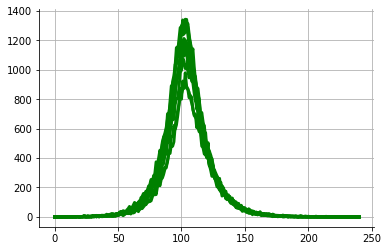

In [49]:
# Note: this is computationally expensive

# Run the model 20 times, sum over all age classes and arrondissements, show the new hospitalisations
fig,ax=plt.subplots()
for i in range(20):
    out=model.sim('21-09-2020',excess_time=50,checkpoints=chk)
    sumNIS=out.sum(dim="place").sum(dim="Nc")
    plt.plot(out["time"].values,sumNIS["H_in"].values,alpha=0.05,color='green')

## Visualisation on a map

### Read the arrondissements shape file

#### Comments Michiel
* Read shapefiles with the Belgian municipalities from the raw data directory
* Appear to be rather heavy files or command
* `gemeentes` is a geodataframe with different geographical classifications in three languages (`FR`, `DU`, `GE`) and a unique `CODE_INS`. Every commune is part of an `arrond` (11 through 93), and is associated with a polygon of GPS coordinates.
* `dissolve` is an important geopandas statement that collects areas together

In [132]:
# Read shape file
gemeentes = gp.read_file("../../data/raw/geopandas/BE/BELGIUM__Municipalities.shp")

# select the columns that you with to use for the dissolve and that will be retained
gemeentes_new = gemeentes[['arrond','geometry']]

# dissolve the state boundary by region: new dataframe with 'arrond' as index and 'geometry' as only column
arrondissementen = gemeentes_new.dissolve(by='arrond')
arrondissementen.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 43 entries, 11 to 93
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  43 non-null     geometry
dtypes: geometry(1)
memory usage: 1.9+ KB


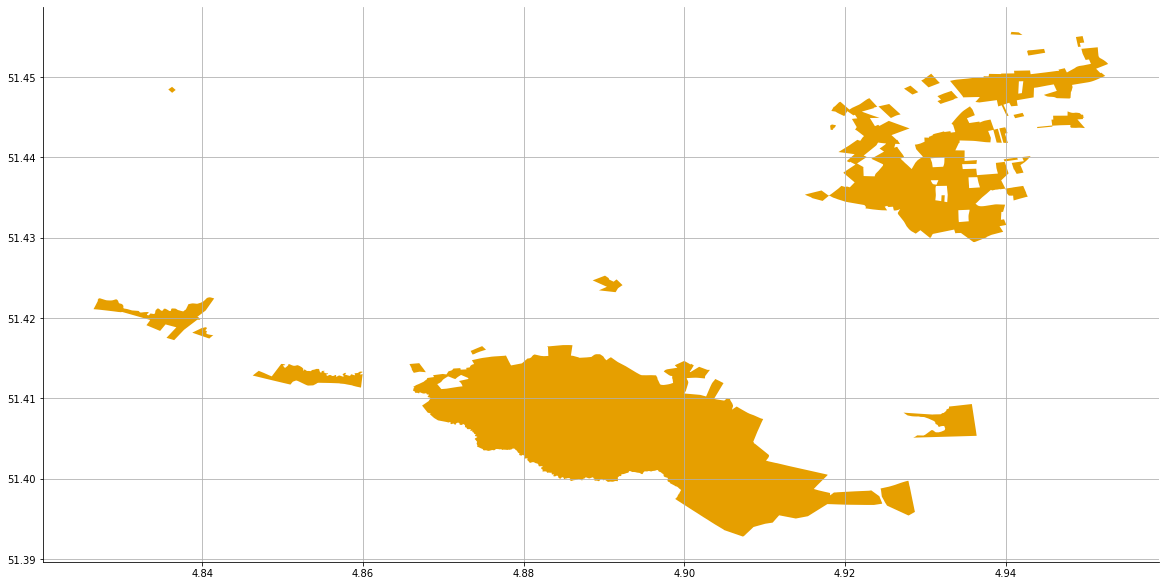

In [145]:
# Demo of GeoPandas's visual power
demo_commune = 'Baarle-Hertog'
gemeentes[gemeentes['Communes']==demo_commune].plot(figsize=(20,20))

### Perform a single simulation

#### Comments Michiel
* Again note that different simulations give *very* different results (more than order of magnitude difference)! Run code below a couple of time to see this.
* The plot below shows whether the pandemic was 'serious': it shows whether it is worth making a gif from
* In images the cumulative data is shown. In the plot below as well.
* The statement `out.sum(dim="Nc")['M'][:,day]` can be made more efficient with cumsumNIS_M (but not really necessary)
* x100 in `data2plot` because we want to show the percentage
* `norm=colors.LogNorm`: Normalize a given value to the 0-1 range on a log scale.
* I'm not sure what the difference is between the first frame and the other frames (legend on/off?)
* 

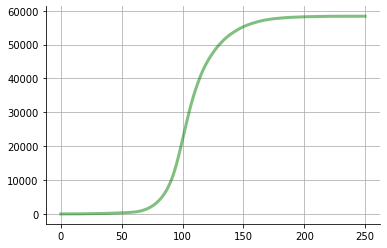

In [124]:
# simulation for 250 days (after March 15th) with the measure changes defined above
out=model.sim(250,checkpoints=chk)

# Again sum over all ages and arrondissements, and show people that are mildly affected on a national level
sumNIS=out.sum(dim="NIS").sum(dim="Nc")
cumsumNIS_M = np.cumsum(sumNIS["M"]) # sumNIS["M"]
plt.plot(out["time"], cumsumNIS_M, alpha=0.5, color='green')

In [131]:
output_path = 'results/maps'

# create the plot
fig, ax = plt.subplots(figsize = (12,12)) # 1200 pixels x 1200 pixels

start = 0

# Create daily images for a .gif
for day in range(start,len(out['time'].values)):
    # Get data
    # Sum over age classes (not interested in those yet) and show the percentage of mildly symptomatic people
    data2plot = out.sum(dim="Nc")['M'][:,day].values / initN_df['total'].values*100
    
    # Make new 'data' column with the cumulative mildly symptomatic people that is updated every iteration
    arrondissementen['data'] = data2plot
    
    # Visualize data
    # Only produce a legend in the first frame?
    if day == start:
        fig = arrondissementen.plot(column = 'data', ax=ax, cmap='plasma',
                                    norm=colors.LogNorm(vmin=0.001, vmax=1), legend=True, edgecolor = 'k')
    else:
        fig = arrondissementen.plot(column = 'data', ax=ax, cmap='plasma',
                                    norm=colors.LogNorm(vmin=0.001, vmax=1), legend=False, edgecolor = 'k')
    # Disable axis
    ax.set_axis_off()
    # This will save the figure as a high-res png in the output path. You can also save as svg if you prefer.
    chart = fig.get_figure()
    chart.savefig(output_path + str(day) + '_B.jpg' ,dpi=100)
    
    plt.close()

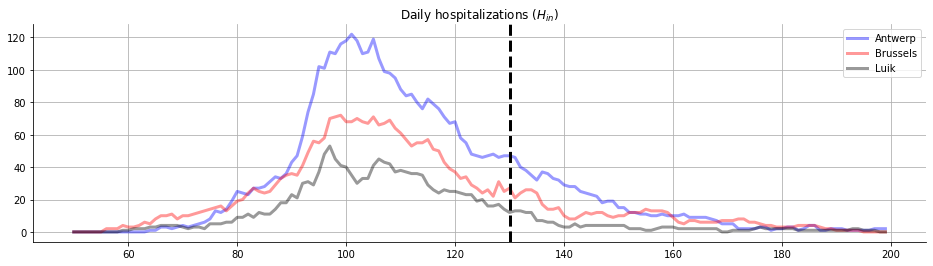

In [130]:
fig,ax=plt.subplots()
fig.set_size_inches(16, 4)
ax.plot(out['time'][50:200],out.sel(NIS=name2nis('arrondissement antwerpen')).sum(dim='Nc')['M'][50:200],color='blue',alpha=0.40)
ax.plot(out['time'][50:200],out.sel(NIS=name2nis('arrondissement brussel-hoofdstad')).sum(dim='Nc')['M'][50:200],color='red',alpha=0.40)
ax.plot(out['time'][50:200],out.sel(NIS=name2nis('arrondissement luik')).sum(dim='Nc')['M'][50:200],color='black',alpha=0.40)
ax.legend(['Antwerp','Brussels','Luik'])
ax.axvline(130,color='black',linestyle='dashed')
ax.set_title('Daily hospitalizations $(H_{in})$')
fig.savefig('daily_hosp.jpg',dpi=300)